In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
# from sklearn.linear_model import LinearRegression
# from sklearn import linear_model
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score, accuracy_score

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(0.0, 25691.16)

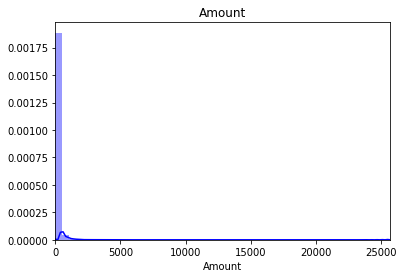

In [3]:
#Counts of transcations by Class
data.groupby(['Class'], as_index=False).size().reset_index(name= 'Counts')

#Drop Time column as it does not seem to have a significance to data
#data= data.drop('Time', axis=1)

#Plot the 2 remaining non PCA columns- Time and Amount

amt_plt= sns.distplot(data['Amount'], color='b')
amt_plt.set_title('Amount')
amt_plt.set_xlim([min(data['Amount']), max(data['Amount'])])

In [4]:
data['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [5]:
#Using RobustScaler as it is not prone to outliers

robust_scaler= RobustScaler()

data['rs_amount']=robust_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['rs_time']=robust_scaler.fit_transform(data['Time'].values.reshape(-1,1))
data= data.drop(['Amount', 'Time'], axis=1)


X= data.drop('Class', axis=1)
y= data['Class']

In [6]:
sss= StratifiedShuffleSplit(n_splits=5, test_size= 0.3, random_state=0)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

,Class,Counts
0,0,492
1,1,492


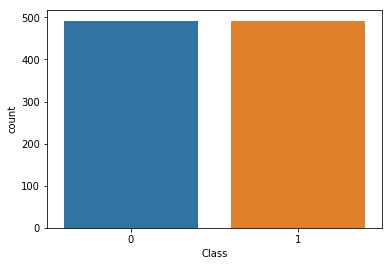

In [7]:
#Create 50/50 undersample data for training model

# Get count of fraud transcations
fraud_count= len(data[data['Class']==1])

# Shuffle data
temp_data= data.sample(frac= 1)

#Create fraud and real transaction dataframes
fraud_data= temp_data.loc[temp_data['Class']== 1]
real_data= temp_data.loc[temp_data['Class']== 0][:fraud_count]

#Create new undersample df and shuffle again
data_undersample= pd.concat([fraud_data, real_data])
data_undersample= data_undersample.sample(frac= 1)

#Get count and plot
sns.countplot(data_undersample['Class'])
data_undersample.groupby(['Class'], as_index=False).size().reset_index(name= 'Counts')

In [8]:
undersample_X= data_undersample.drop('Class', axis=1)
undersample_y= data_undersample['Class']
undersample_X, undersample_y

undersample_Xtrain, undersample_Xtest, undersample_ytrain, undersample_ytest = train_test_split(undersample_X, undersample_y, test_size = 0.3, random_state = 0)

In [9]:
logreg_params={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}

#Added solver saga to repress warnings- saga recommended by sklearn
grid_logreg= GridSearchCV(LogisticRegression(solver= 'liblinear'), logreg_params, cv=5)
grid_logreg.fit(undersample_Xtrain, undersample_ytrain)

logreg= grid_logreg.best_estimator_

print('Best Penalty:', grid_logreg.best_estimator_.get_params()['penalty'])
print('Best C:', grid_logreg.best_estimator_.get_params()['C'])
c_value= grid_logreg.best_estimator_.get_params()['C']
pen_value= grid_logreg.best_estimator_.get_params()['penalty']

Best Penalty: l2
Best C: 1


Text(0.5,15,'Predicted label')

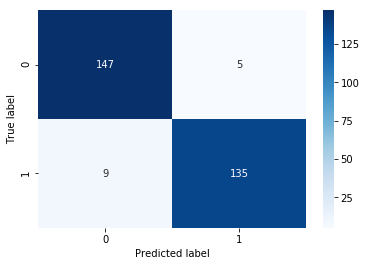

In [10]:
#Confusion matrix for undersample data
undersample_ypred= logreg.predict(undersample_Xtest)
cnf_matrix = confusion_matrix(undersample_ytest, undersample_ypred)

df_cnf_matrix= pd.DataFrame(cnf_matrix)
sns.heatmap(df_cnf_matrix, annot=True, fmt='g', cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

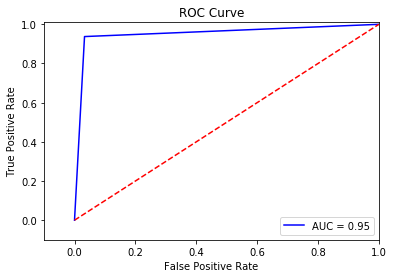

In [11]:
fpr, tpr, thresholds = roc_curve(undersample_ytest, undersample_ypred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5,15,'Predicted label')

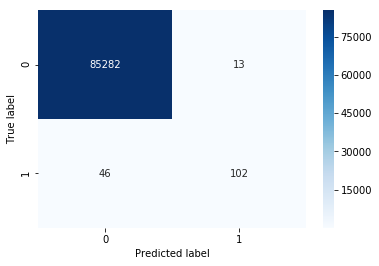

In [15]:
#Train model with values found with undersampled data

logreg=LogisticRegression(C= c_value, penalty= pen_value, solver= 'liblinear')
logreg.fit(X_train, y_train)
y_pred= logreg.predict(X_test)
cnf_matrix_full = confusion_matrix(y_test, y_pred)

df_cnf_matrix_full= pd.DataFrame(cnf_matrix_full)
sns.heatmap(df_cnf_matrix_full, annot=True, fmt='g', cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

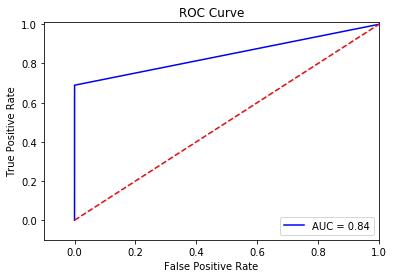

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Recall Score: 0.69
Precision Score: 0.89
F1 Score: 0.78
Accuracy Score: 1.00
